Total Characters:  167513
Total Vocabulary:  59
 Characters/Words mapping 
{'t': 0, '4': 1, 'l': 2, 'v': 3, 'q': 4, '#': 5, 'y': 6, ']': 7, '\r': 8, '5': 9, 'r': 10, 'p': 11, ';': 12, '$': 13, '[': 14, '\n': 15, 's': 16, 'k': 17, 'n': 18, '%': 19, ',': 20, '3': 21, '(': 22, '/': 23, 'b': 24, "'": 25, '2': 26, 'w': 27, ' ': 28, '.': 29, '9': 30, '8': 31, 'i': 32, 'z': 33, 'j': 34, '0': 35, '_': 36, '!': 37, 'd': 38, 'm': 39, 'f': 40, ')': 41, '*': 42, '?': 43, 'u': 44, 'c': 45, '1': 46, '7': 47, '6': 48, 'o': 49, 'g': 50, 'a': 51, '"': 52, 'h': 53, 'e': 54, '@': 55, ':': 56, '-': 57, 'x': 58}
{0: 't', 1: '4', 2: 'l', 3: 'v', 4: 'q', 5: '#', 6: 'y', 7: ']', 8: '\r', 9: '5', 10: 'r', 11: 'p', 12: ';', 13: '$', 14: '[', 15: '\n', 16: 's', 17: 'k', 18: 'n', 19: '%', 20: ',', 21: '3', 22: '(', 23: '/', 24: 'b', 25: "'", 26: '2', 27: 'w', 28: ' ', 29: '.', 30: '9', 31: '8', 32: 'i', 33: 'z', 34: 'j', 35: '0', 36: '_', 37: '!', 38: 'd', 39: 'm', 40: 'f', 41: ')', 42: '*', 43: '?', 44: 'u', 45:

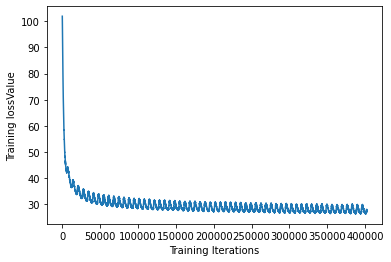

In [ ]:
import urllib
import re
import numpy as np
from random import uniform
from urllib.request import urlopen
import matplotlib.pyplot as plt


class Color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


def read_text_file(url):
    # Open text-file and return a separated input and output variable(series of words)
    text_file = urllib.request.urlopen(url)
    file_data = text_file.read()
    file_data = file_data.decode('utf8').lower()
    file_chars = set(file_data)
    file_data_size, file_vocab_size = len(file_data), len(file_chars)
    return file_data, file_data_size, file_vocab_size, file_chars


# Sigmoid/ Sigmoid Derivative/Tangent/ Tangent Derivative/Softmax function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


def tangent(x):
    return np.tanh(x)


def d_tangent(self, x):
    return 1 - np.tanh(x) ** 2


def softmax(x):
    return (np.exp(x - np.max(x))) / np.sum(np.exp(x - np.max(x)))


class LSTM:
    # Class constructor
    def __init__(self, char_map, idx_map, unique_num, iterations=10, learning_r=0.01, firstBeta=0.9, secondBeta=0.999):
        # Number of hidden layers and Batch Size
        hiddenNum = 100
        batchSize = 25

        # Initiate parameters, gradient, and parameters for adam dictionaries
        self.parameters = {}
        self.gradients = {}
        self.adam = {}

        # First and Second Beta, initiated at 0.9 and 0.999
        self.firstBeta = firstBeta
        self.secondBeta = secondBeta

        # Batch size
        self.batch_size = batchSize

        # Number of Epochs, initiated at 10
        self.epochNum = iterations

        # Learning rate, initiated at 0.01
        self.learningRate = learning_r

        # charMap and indexMap: Character and Index Mapping
        self.charMap = char_map
        self.indexMap = idx_map

        # Number of Hidden Layers and unique characters
        self.uniqueNum = unique_num
        self.hiddenNum = hiddenNum

        # Initialize Xavier function
        xavier = (1.0 / np.sqrt(self.uniqueNum + self.hiddenNum))

        # Weight and Beta key Initiation. This includes forget, cell, Output, and total parameters
        self.parameters["WeightForget"] = np.random.randn(self.hiddenNum, self.hiddenNum + self.uniqueNum) * xavier
        self.parameters["betaForget"] = np.ones((self.hiddenNum, 1))

        self.parameters["WeightInput"] = np.random.randn(self.hiddenNum, self.hiddenNum + self.uniqueNum) * xavier
        self.parameters["betaInput"] = np.zeros((self.hiddenNum, 1))

        self.parameters["WeightCell"] = np.random.randn(self.hiddenNum, self.hiddenNum + self.uniqueNum) * xavier
        self.parameters["betaCell"] = np.zeros((self.hiddenNum, 1))

        self.parameters["WeightOutput"] = np.random.randn(self.hiddenNum, self.hiddenNum + self.uniqueNum) * xavier
        self.parameters["betaOutput"] = np.zeros((self.hiddenNum, 1))

        self.parameters["WeightTotal"] = np.random.randn(self.uniqueNum, self.hiddenNum) * \
                                         (1.0 / np.sqrt(self.uniqueNum))
        self.parameters["betaTotal"] = np.zeros((self.uniqueNum, 1))

        # Initiate derivative, meter, and value for Weight and Beta key.
        for gate in self.parameters:
            self.gradients["derivative" + gate] = np.zeros_like(self.parameters[gate])
            self.adam["meter" + gate] = np.zeros_like(self.parameters[gate])
            self.adam["value" + gate] = np.zeros_like(self.parameters[gate])

        self.lossSmooth = -np.log(1.0 / self.uniqueNum) * self.batch_size
        return

    # Clip function to limit gradients to conservative value
    def gradientClip(self):
        for gate in self.gradients:
            np.clip(self.gradients[gate], -5, 5, out=self.gradients[gate])
        return

    # Reset the gradient to zero
    def gradientClear(self):
        for gate in self.gradients:
            self.gradients[gate].fill(0)
        return

    # Using Adam function, update the parameters
    def parametersUpdate(self, batch_num):
        for gate in self.parameters:
            self.adam["meter" + gate] = self.adam["meter" + gate] * self.firstBeta + \
                                        (1 - self.firstBeta) * self.gradients["derivative" + gate]
            self.adam["value" + gate] = self.adam["value" + gate] * self.secondBeta + \
                                        (1 - self.secondBeta) * self.gradients["derivative" + gate] ** 2
            
            # accumulated gradients are updated for all time steps
            crl_Meter = self.adam["meter" + gate] / (1 - self.firstBeta ** batch_num)
            crl_Value = self.adam["value" + gate] / (1 - self.secondBeta ** batch_num)

            self.parameters[gate] -= self.learningRate * crl_Meter / (np.sqrt(crl_Value) + 1e-7)
        return

    # Generate sample text
    def outputResult(self, prev_hidden, prev_cell, sample_size):
        # Variable Initiation
        inputMatrix = np.zeros((self.uniqueNum, 1))
        curr_hidden = prev_hidden
        curr_cell = prev_cell
        outputLine = ""
        # Output random lines for the result
        for count in range(sample_size):
            token, _, curr_hidden, _, curr_cell, _, _, _, _ = self.forwardProp(inputMatrix, curr_hidden, curr_cell)
            randomInterval = np.random.choice(range(self.uniqueNum), p=token.ravel())
            inputMatrix = np.zeros((self.uniqueNum, 1))
            inputMatrix[randomInterval] = 1
            tempWord = self.indexMap[randomInterval] # match char with relative index
            outputLine += tempWord # concat to final string
        return outputLine

    # Forward prop function definition
    def forwardProp(self, predictor, prev_hidden, prev_cell):
        # Weight, forget, input, cell variable initialization
        weight = np.row_stack((prev_hidden, predictor))

        forget = sigmoid(np.dot(self.parameters["WeightForget"], weight) + self.parameters["betaForget"])

        # previous hidden states as input
        input_d = sigmoid(np.dot(self.parameters["WeightInput"], weight) + self.parameters["betaInput"])

        # previous cell as input
        cell = np.tanh(np.dot(self.parameters["WeightCell"], weight) + self.parameters["betaCell"])

        cur_cell = forget * prev_cell + input_d * cell
        temp_sig = sigmoid(np.dot(self.parameters["WeightOutput"], weight) + self.parameters["betaOutput"])
        cur_hidden = temp_sig * np.tanh(cur_cell)

        value = np.dot(self.parameters["WeightTotal"], cur_hidden) + self.parameters["betaTotal"]
        token = softmax(value)
        return token, value, cur_hidden, temp_sig, cur_cell, cell, input_d, forget, weight

    # Backward prop function definition
    def backwardProp(self, realValue, token, af_d_hidden, af_d_cell, prev_cell, weight, forget, input_d, cell, cur_cell, tempsig, currhidden):
        d_total = np.copy(token)
        d_total[realValue] -= 1

        self.gradients["derivativeWeightTotal"] += np.dot(d_total, currhidden.T)
        self.gradients["derivativebetaTotal"] += d_total

        d_hidden = np.dot(self.parameters["WeightTotal"].T, d_total)
        d_hidden += af_d_hidden

        d_Sigmoid = d_hidden * np.tanh(cur_cell)
        dsig = d_Sigmoid * tempsig * (1 - tempsig)
        self.gradients["derivativeWeightOutput"] += np.dot(dsig, weight.T)
        self.gradients["derivativebetaOutput"] += dsig

        d_cell = d_hidden * tempsig * (1 - np.tanh(cur_cell) ** 2)
        d_cell += af_d_cell

        d_cell_backward = d_cell * input_d
        d_cell_final = d_cell_backward * (1 - cell ** 2)
        self.gradients["derivativeWeightCell"] += np.dot(d_cell_final, weight.T)
        self.gradients["derivativebetaCell"] += d_cell_final

        d_input = d_cell * cell
        d_input_final = d_input * input_d * (1 - input_d)
        self.gradients["derivativeWeightInput"] += np.dot(d_input_final, weight.T)
        self.gradients["derivativebetaInput"] += d_input_final

        d_forget = d_cell * prev_cell
        d_forget_final = d_forget * forget * (1 - forget)
        self.gradients["derivativeWeightForget"] += np.dot(d_forget_final, weight.T)
        self.gradients["derivativebetaForget"] += d_forget_final

        # Sum up all gradients
        d_final = (np.dot(self.parameters["WeightForget"].T, d_forget_final)
              + np.dot(self.parameters["WeightInput"].T, d_input_final)
              + np.dot(self.parameters["WeightCell"].T, d_cell_final)
              + np.dot(self.parameters["WeightOutput"].T, dsig))

        prev_d_hidden = d_final[:self.hiddenNum, :]
        prev_d_cell = forget * d_cell
        return prev_d_hidden, prev_d_cell

    # Forward and Backward Prop Function
    def forbackProp(self, batchPred, batchRes, prev_hidden, prev_cell):
        # Initiate empty dictionaries to store results
        predictor, weight = {}, {}
        forget, input__, cell, curr_cell, temp_sig = {}, {}, {}, {}, {}
        token, value, curr_hidden = {}, {}, {}
        curr_hidden[-1] = prev_hidden
        curr_cell[-1] = prev_cell

        # Iterate time steps and store results into dictionaries
        lossValue = 0
        for count in range(self.batch_size):
            predictor[count] = np.zeros((self.uniqueNum, 1))
            predictor[count][batchPred[count]] = 1

            token[count], value[count], curr_hidden[count], temp_sig[count], curr_cell[count], cell[count], input__[
                count], forget[count], weight[count] = self.forwardProp(predictor[count], curr_hidden[count - 1],
                                                                         curr_cell[count - 1])

            lossValue += -np.log(token[count][batchRes[count], 0])

        self.gradientClear()

        after_d_hidden = np.zeros_like(curr_hidden[0])
        after_d_cell = np.zeros_like(curr_cell[0])

        # Feeding first LSTM cell to next training batch
        for count in reversed(range(self.batch_size)):
            after_d_hidden, after_d_cell = self.backwardProp(batchRes[count], token[count], after_d_hidden,
                                                              after_d_cell, curr_cell[count - 1], weight[count],
                                                              forget[count], input__[count],
                                                              cell[count], curr_cell[count], temp_sig[count],
                                                              curr_hidden[count])
        return lossValue, curr_hidden[self.batch_size - 1], curr_cell[self.batch_size - 1]

    # Model train function
    def modelTrain(self, data_):
        # Initialize loss list, batch count and batchData
        loss_list = []
        batchCount = len(data_) // self.batch_size
        batchData = data_[: batchCount * self.batch_size] # trim chars at the end of input to form complete sequence

        # Iterate over training batch to fit length of sequence
        for epochCount in range(self.epochNum):
            prev_hidden = np.zeros((self.hiddenNum, 1))
            prev_cell = np.zeros((self.hiddenNum, 1))

            for count in range(0, len(batchData) - self.batch_size, self.batch_size):
                batchPred = [self.charMap[ch] for ch in batchData[count: count + self.batch_size]]
                batchRes = [self.charMap[ch] for ch in batchData[count + 1: count + self.batch_size + 1]]

                lossValue, prev_hidden, prev_cell = self.forbackProp(batchPred, batchRes, prev_hidden, prev_cell)
                self.lossSmooth = self.lossSmooth * 0.999 + lossValue * 0.001 # tune up loss result
                loss_list.append(self.lossSmooth) # append loss result to loss_list

                self.gradientClip() # limit gradient value

                batch_num = epochCount * self.epochNum + count / self.batch_size + 1
                self.parametersUpdate(batch_num)

                # output the result
                if count % 100000 == 0:
                    print(Color.BOLD, 'Iteration:', epochCount, '\tBatch:', count, "-", count + self.batch_size,
                          '\tLoss:', round(self.lossSmooth, 2), Color.END)
                    result = self.outputResult(prev_hidden, prev_cell, sample_size=250)
                    print(result, "\n") # print result

        return loss_list, self.parameters

# Main Program
if __name__ == "__main__":
    path = "https://datasetdanny.s3.amazonaws.com/alice.txt"
    data, data_size, uniqueNum, chars = read_text_file(path)

    print("Total Characters: ", data_size)
    print("Total Vocabulary: ", uniqueNum)

    # Creating character/word mappings
    charMap = {ch: __input for __input, ch in enumerate(chars)}
    indexMap = {__input_: ch for __input_, ch in enumerate(chars)}
    print(Color.BOLD, "Characters/Words mapping", Color.END)
    print(charMap)
    print(indexMap)

    print(Color.BOLD, "Initialize parameters.......", Color.END)
    epochNum = 60
    learningRate = 0.003

    print(Color.BOLD, "Iterations: ", epochNum, Color.END)
    print(Color.BOLD, "Learning rate: ", learningRate, Color.END)

    model = LSTM(charMap, indexMap, uniqueNum, epochNum, learningRate)
    lossList, parameters = model.modelTrain(data)

    plt.plot([input_data for input_data in range(len(lossList))], lossList)
    plt.xlabel("Training Iterations")
    plt.ylabel("Training lossValue")
